A shuttling model of two sites, with two valleys per site, can be written as:
$$
H = \left(\begin{matrix}
    \varepsilon/2 + |\Delta_L| & 0 & t_{ee} & t_{eg} \\
    0 & \varepsilon/2-|\Delta_L| & t_{ge} & t_{gg} \\
    t_{ee}^* & t_{ge}^* & -(\varepsilon/2) + |\Delta_R| & 0 \\
    t_{eg}^* & t_{gg}^* & 0 & -(\varepsilon/2) - |\Delta_R| 
\end{matrix}\right),
$$
where $\varepsilon$ is the driving parameter, $\Delta_{L,R}$ are the intervalley coupling, and the tunneling rates read
$$
\begin{align}
    t_{ee}&=t_{gg}^*=\frac{t_c}{2}\left(1+e^{i(\phi_L-\phi_R)}\right),\\
    t_{eg}&=-t_{ge}^*=\frac{t_c}{2}\left(e^{i\phi_L}-e^{i\phi_R}\right).
\end{align}
$$

In this notebook, we obtain the band structure of this system, and obtain the pulses for an adiabatic transfer following the first excited stated. We compare the results for a pure system, with those obtained with a Lindblad master equation given by $\dot{\rho}=-i[H,\rho]+\mathcal{D}[\rho]$ using the jump operator $\mathcal{D}[\rho]=(1/T_2)(\text{diag}(\rho)-\rho)$.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorstamps

from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.QUAD_utils import compute_x_quad
from HQUAD_lib.hamiltonians import two_valleys_system
from HQUAD_lib.physics_utils import fidelity_shuttling

# Band structure

In [2]:
tc = 1
phiL = 0 * np.pi
phiR = 0.8 * np.pi
DeltaL = 1
DeltaR = 2

eps_s = np.linspace(-10, 10, 2 ** 15 + 1)

partial_hamiltonian = np.array([two_valleys_system(1, 0, 0, 0, 0, 0) for _ in range(len(eps_s))])

hypermatrix = np.array([two_valleys_system(eps, tc, phiL, phiR, DeltaL, DeltaR) for eps in eps_s])
eigvalues, eigmodes = np.linalg.eigh(hypermatrix)

# Pulses

In [55]:
alphas = np.linspace(-5, 5, 5)  # Increase sample rate to enhance resolution
betas = alphas

limit_sup = 1e10

result = parameter_run(compute_x_quad, [['alpha'], ['beta']], [[alphas], [betas]], energies=eigvalues, states=eigmodes,
                        x_vec=eps_s, partial_hamiltonian=partial_hamiltonian, adiabatic_state=1, limit_sup=limit_sup)

s = result[0][0]
eps_sol = result[1].reshape((len(alphas), len(betas), len(s)))

compute_x_quad: [['alpha'], ['beta']]:   0%|          | 0/25 [00:00<?, ?it/s]

# No dephasing

In [56]:
n_tf = 10  # Increase to get better results
tf_list = np.linspace(0.1, 100, n_tf)

fidelitites_pure = parameter_run(fidelity_shuttling, [['pulse'], ['tf']], [[eps_sol.reshape((-1, len(s)))], [tf_list]], tc=tc, phiL=phiL,
                                 phiR=phiR, DeltaL=DeltaL, DeltaR=DeltaR)

fidelitites_pure = fidelitites_pure.reshape((len(alphas), len(betas), n_tf))

fidelity_shuttling: [['pulse'], ['tf']]:   0%|          | 0/250 [00:00<?, ?it/s]

# Dephasing

In [57]:
gamma = 0.01
fidelities_dephasing = parameter_run(fidelity_shuttling, [['pulse'], ['tf']], [[eps_sol.reshape((-1, len(s)))], [tf_list]], tc=tc, phiL=phiL,
                                 phiR=phiR, DeltaL=DeltaL, DeltaR=DeltaR, gamma=gamma)

fidelities_dephasing = fidelities_dephasing.reshape((len(alphas), len(betas), n_tf))

fidelity_shuttling: [['pulse'], ['tf']]:   0%|          | 0/250 [00:00<?, ?it/s]

# Plots

In [58]:
def plot_fidelity(axs, fidelities, tf_list, alphas, betas, clabel=True):
    cmap_fidelity = mpl.colormaps['viridis_r']
    cmap_times = mpl.colormaps['inferno_r']
    
    cmap_fidelity.set_bad('white')
    cmap_times.set_bad('white')
    
    max_fidelity = np.max(fidelities[..., :], axis=2)
    tf_tilde = tf_list[np.argmax(fidelities[..., :], axis=2)]
    
    data_fidelity = np.log10(1 - max_fidelity)
    data_fidelity[max_fidelity == 0] = np.nan
    data_tf = tf_tilde
    data_tf[max_fidelity == 0] = np.nan
    
    vmax_F = np.max(np.log10(1 - max_fidelity))
    vmin_F = np.min(np.log10(1 - max_fidelity))
    
    vmax_tf = np.max(tf_tilde)
    vmin_tf = np.min(tf_tilde)
    
    im0 = axs[0].contourf(alphas, betas, data_fidelity.T, levels=15, vmin=vmin_F, vmax=vmax_F, cmap=cmap_fidelity)
    im1 = axs[1].contourf(alphas, betas, data_tf.T, levels=15, vmin=vmin_tf, vmax=vmax_tf, cmap=cmap_times)
    
    if clabel:
        label0 = r'$\log_{10}(1 - \tilde{\mathcal{F}})$'
        label1 = r'$\tilde{t}_f\; [1 / t_c]$'
    else:
        label0 = None
        label1 = None
        
    cbar0 = plt.colorbar(im0, ax=axs[0], label=label0, location='top')
    cbar1 = plt.colorbar(im1, ax=axs[1], label=label1, location='top')

    cbar0.ax.set_xticks(cbar0.ax.get_xticks()[::3])
    cbar1.ax.set_xticks(cbar1.ax.get_xticks()[::2])
    
    cbars = [cbar0, cbar1]
    for cbar in cbars:
        cbar.solids.set_edgecolor('face')
    
    for ax in axs:
        ax.set_xlabel(r'$\alpha$')
    
    axs[0].set_ylabel(r'$\beta$')

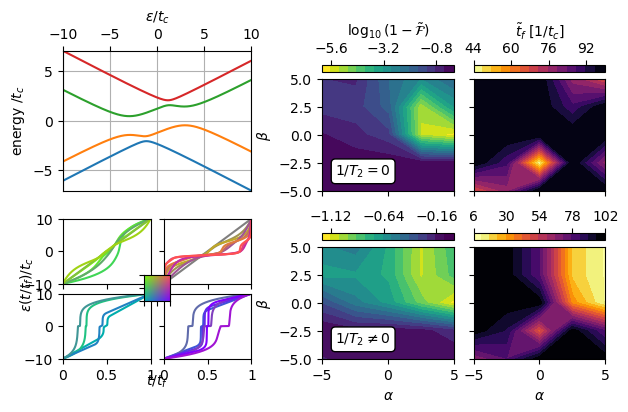

In [60]:
fig = plt.figure(figsize=(7, 4))
gs0 = fig.add_gridspec(1, 2, wspace=0.3, width_ratios=[1, 1.5])

# Band structure
gs00 = gs0[0].subgridspec(2, 1)
axBand = fig.add_subplot(gs00[0])

axBand.plot(eps_s, eigvalues)
axBand.grid()
axBand.set_xlim(min(eps_s), max(eps_s))
axBand.set_ylim(np.min(eigvalues), np.max(eigvalues))

axBand.set_xlabel(r'$\varepsilon / t_c$')
axBand.set_ylabel(r'energy $/t_c$')
axBand.xaxis.tick_top()
axBand.xaxis.set_label_position('top') 

# Fidelity w/o dephasing
gsFidelities = gs0[1].subgridspec(2, 2, wspace=0.15)

axsFidelity = []
for i in range(2):
    for j in range(2):
        axsFidelity.append(fig.add_subplot(gsFidelities[i, j]))
axsFidelity = np.array(axsFidelity).reshape((2, 2))

plot_fidelity(axsFidelity[0], fidelitites_pure, tf_list, alphas, betas)
for ax in axsFidelity[0]:
    ax.set_xticklabels([])
    ax.set_xlabel(None)
axsFidelity[0, 1].set_yticklabels([])

# Fidelity w/ dephasing
plot_fidelity(axsFidelity[1], fidelities_dephasing, tf_list, alphas, betas, clabel=False)
axsFidelity[1, 1].set_yticklabels([])

axsFidelity[0, 0].text(0.1, 0.1, r'$1 / T_2 = 0$', ha='left',
                       transform=axsFidelity[0, 0].transAxes, va='bottom',
                       bbox=dict(boxstyle="round", ec='k', fc='w', alpha=1))

axsFidelity[1, 0].text(0.1, 0.1, r'$1 / T_2 \neq 0$', ha='left',
                       transform=axsFidelity[1, 0].transAxes, va='bottom',
                       bbox=dict(boxstyle="round", ec='k', fc='w', alpha=1))

# Pulses
gsPulses = gs00[1].subgridspec(2, 2, wspace=0.15, hspace=0.15)
axsPulses = []
for i in range(2):
    for j in range(2):
        axsPulses.append(fig.add_subplot(gsPulses[i, j]))
axsPulses = np.array(axsPulses).reshape((2, 2))

rgb, stamp = colorstamps.apply_stamp(*np.meshgrid(betas, alphas), 'teuling0f')

lines = []
for i in range(len(alphas)):
    for j in range(len(betas)):
        if alphas[i] >= 0:
            column = 1
        else:
            column = 0

        if betas[j] >= 0:
            row = 0
        else:
            row = 1

        axsPulses[row, column].plot(s, eps_sol[i, j], c=rgb[i, j])
 
for ax in axsPulses.flatten():
    ax.set_xlim(0, 1)
    ax.set_ylim(-10, 10)
 
for ax in axsPulses[-1]:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])

axsPulses[1, 0].text(1.07, -0.4, r'$t / t_f$', ha='center', transform=axsPulses[1, 0].transAxes)
axsPulses[1, 0].text(-0.5, 1.15, r'$\varepsilon(t / t_f) /t_c$', va='center', rotation='vertical',
                     transform=axsPulses[1, 0].transAxes)

for ax in axsPulses[:, 1]:
    ax.set_yticklabels([])

for ax in axsPulses[0]:
    ax.set_xticklabels([])

overlaid_ax = stamp.overlay_ax(axsPulses[1, 0], width=0.3, lower_left_corner=[0.88, 0.92])
overlaid_ax.set_xticklabels([])
overlaid_ax.set_yticklabels([]);